In [34]:
from matplotlib import pyplot as plt
import numpy as np
import camb
from camb import model 
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy import constants as const
from scipy.integrate import cumtrapz
from matplotlib.ticker import MultipleLocator

Set-up
====

In order to compute the pdf of the convergence $\kappa$ (and magnification $\mu$), a cosmology should be assumed. Below [CAMB](https://github.com/cmbant/CAMB) is used to calulate this pdf for various redshifts.

In [48]:
# Cosmology 

h = 0.7
Oc = 0.27
Ob = 0.03
Om = Ob+Oc
cosmo = FlatLambdaCDM(H0=h*100, Om0=Oc+Ob)
H0 = h*100*u.km/u.s/u.Mpc

betagw = 2.3


# Other parameters for numerical calculations
N_zs = 20
filetau = np.loadtxt("plot", delimiter=",") # filetau is the lensing depth tau(mu>10) as a function of z

#Numerical grids
zs = np.geomspace(1e-2, 10, N_zs)
zp = np.linspace(0, 10., N_zs)
mu = np.geomspace(1e-1,1e5, 300)
mu[mu==mu[mu>1][0]] = 1 # make sure there is a point exactly at 1



In [ ]:
print("Running CAMB")

zp = np.linspace(0, 10., N_zs)

pars = camb.CAMBparams()
pars.set_cosmology(H0=h*100, ombh2=Ob*h**2., omch2=Oc*h**2., omk=0)
pars.InitPower.set_params(As=2e-9, ns=0.965)
pars.InitPower.set_params(ns=0.965)

pars.NonLinear = model.NonLinear_both
pars.set_matter_power(redshifts=zp, kmax=3e3)
results = camb.get_results(pars)
results.calc_power_spectra(pars)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=1e-4, maxkh=3e3, npoints = 50)    

IP = np.trapz(pk_nonlin * h**3. * (kh_nonlin * h)**2. , np.log(kh_nonlin * h))/2./np.pi

print("Power spectrum integrals")



Ichi2 = np.zeros(len(zs)) * u.Mpc**3.
Ichi = np.zeros(len(zs)) * u.Mpc**2.
for i, z in enumerate(zs):
    za = np.linspace(0., z, 100000)
    chi = cosmo.comoving_distance(za)
    chis = cosmo.comoving_distance(z)
    Ichi2[i] = np.trapz((chi*(1.-chi/chis)*(1.+za))**2. * np.interp(za, zp[::-1], IP[::-1]), chi)
    Ichi[i] = np.trapz((chi*(1.-chi/chis)*(1.+za)), chi)


Var_kappa = ((3./2. * H0**2. * Om )**2. * Ichi2 * u.Mpc / const.c**4.).to(1)
Min_kappa = (-3* H0**2. *Om / 2. * Ichi / const.c**2.).to(1)

plt.figure(figsize=(10, 10))
plt.plot(zs, Var_kappa, label='variance kappa')
plt.legend()
plt.show()

Lensing pdf
===

In [ ]:
z_array = np.linspace(0, 100, 100000)
dl_array = cosmo.luminosity_distance(z_array)


def dl(z):
    return cosmo.luminosity_distance(z)

def dl_p(z):
    return dl(z)/(1.+z) + (1.+z)/E(z) * const.c / cosmo.H0

def E(z):
    return np.sqrt(0.3*(1.+z)**3. + 0.7)

def z_p(z, mu):
    return z_array[np.abs(dl(z) * np.sqrt(mu)-dl_array).argmin()]

def Pmu(mu, z, tail=True):
    kappa = 1. - 1./np.sqrt(mu)
    Vkappa = np.interp(z, zs, Var_kappa)
    Mkappa = np.abs(np.interp(z, zs, Min_kappa))
    sigma2 = np.log(1.+Vkappa/Mkappa**2.)
    argexp = - (np.log(1.+kappa/Mkappa)+sigma2/2.)**2. /2. /sigma2
    if tail:
        taumu = np.interp(z, filetau[:,0], filetau[:, 1])
        tail = taumu / mu**(3.) / 0.005
        if(np.array(z).size==1):
            tail[mu<1] = taumu / 3.**(3.) / 0.005
        else:
            tail[mu<1] = taumu[mu<1] / 3.**(3.) / 0.005
        result = (1.-kappa)**3. / 2. *\
            1./np.sqrt(2*np.pi*sigma2) * np.exp(argexp) * \
            1./(kappa+Mkappa) * np.exp(-(mu/3.)**4.)
        result[~np.isfinite(result)] = 0
        return result + tail
    else:
        return (1.-kappa)**3. / 2. *\
            1./np.sqrt(2*np.pi*sigma2) * np.exp(argexp) * \
            1./(kappa+Mkappa) * np.exp(-(mu/3)**4.)

def Pkappa(kappa, z):
    Vkappa = np.interp(z, zs, Var_kappa)
    Mkappa = np.abs(np.interp(z, zs, Min_kappa))
    sigma2 = np.log(1.+Vkappa/Mkappa**2.)
    argexp = - (np.log(1.+kappa/Mkappa)+sigma2/2.)**2. /2. /sigma2
    return 1./np.sqrt(2*np.pi*sigma2) * np.exp(argexp) * 1./(kappa+Mkappa)


plt.figure(figsize=(3, 3))
kappa = np.linspace(-0.6, 2., 1000)
colors = ['brown', 'k', 'b', 'orange', 'purple', 'green']
for i, z in enumerate([0.1, 1., 2., 3., 5, 10]):
    plt.loglog(1.+kappa, (1.+kappa)*Pkappa(kappa, z), label=str(z), color=colors[i])
plt.gca().set_xlim([0.35, 4.])
plt.gca().set_ylim([1e-5, 1e2])
plt.gca().set_xlabel('1+kappa')
plt.gca().set_ylabel('dP/dlog(1+kappa)')
plt.legend()
plt.show()



plt.figure(figsize=(4, 3))
colors = ['b', 'g', 'k', 'r']

for i, z in enumerate([1, 3, 6, 10]):
    plt.loglog(mu, mu*(Pmu(mu, z, tail=True)) , label='$z = '+str(z)+'$', color=colors[i])
    plt.loglog(mu, mu*(Pmu(mu, z, tail=False)) , color=colors[i], ls='--')
plt.gca().set_xlim([1e-1, 1e3])
plt.gca().set_ylim([1e-7, 2e1])
plt.gca().set_xlabel('magnification $\mu$')
plt.gca().set_ylabel('$\mu P(\mu, z)$')
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

Figures
======

The snippets below calculate the plots shown in the paper. These can be seen as examples of how to use $P(\mu, z)$ and they can be run separately to experiment with the various elements. The array **KGW** as a function of **M_p_a** contains the weights mentioned in the original paper as a function of intrinsic mass. Because the variable **M_p_a** really refers to the ratio between intrisic and observed masses, implementing power-law mass functions is particularly easy, just multiply KGW by the appropriate power of **M_p_a**.

The last snippet involves an integral of these weights multiplied by a power-law mass function. 

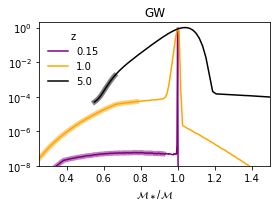

In [43]:
# Lensing weights for GW transients, chirp-mass

colors = ['purple', 'orange', 'k']
plt.figure(figsize=(4, 3))
for i, z in enumerate([0.15, 1., 5.]):
    z_p_a = np.array([z_p(z, mui) for mui in mu])
    M_p_a = (1+z)/(1+z_p_a)
    
    PmuGW = Pmu(mu, z_p_a, tail=True)
    
    # Only tail of magnification function 
    taumu = np.interp(z_p_a, filetau[:,0], filetau[:, 1])
    PmuGW2 = taumu / mu**(3.) / 0.005    
    
    J = dl_p(z)/dl_p(z_p_a) * np.sqrt(mu) * (1+z)/(1+z_p_a)
    V = E(z)/E(z_p_a) * mu * ((1+z_p_a)/(1+z))**(-2.)
    Evo = ((1+z_p_a)/(1+z))**(betagw)
    Grad = np.gradient(mu, M_p_a)
    R = (1+z)/(1+z_p_a)
    
    if(z<=2):
        Evo[z_p_a>2.] = Evo[z_p_a>2.] * ((1+z_p_a[z_p_a>2.])/(1+2.))**(-2*betagw)
    else:
        Evo[z_p_a>2.] = ((1+z_p_a[z_p_a>2.])/(1.+z))**(-betagw)
    Evo[z_p_a>10] = np.nan
    
    KGW = J*V*R*PmuGW * np.abs(Grad)*Evo
    KGW2 = J*V*R*PmuGW2 * np.abs(Grad)*Evo
    
    KGW = KGW/np.nanmax(KGW)
    plt.semilogy(M_p_a, KGW, label=str(z), color=colors[i])
    plt.semilogy(M_p_a[mu>3], KGW[mu>3], color=colors[i], lw=5, alpha=0.5)
    

plt.gca().set_xlabel(r'$\mathcal{M}_\ast/\mathcal{M}$')
plt.gca().set_ylim([1e-8, 2])
plt.gca().set_xlim([0.25, 1.5])
plt.legend(frameon=False, title='z')
plt.gca().set_title('GW')
plt.tight_layout()
plt.show()

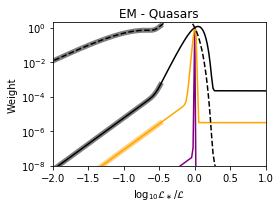

In [44]:
# Lensing weights for persistent EM sources, luminosity
colors = ['purple', 'orange', 'k']
plt.figure(figsize=(4, 3))
for i, z in enumerate([0.15, 1., 5.]):
    z_p_a = np.array([z_p(z, mui) for mui in mu])
    L_p_a = 1/mu
    
    JL = 1/mu
    PmuL = Pmu(mu, z)
    
    KL = PmuL * np.log(10.)
    
    KL = KL/KL[mu==1]
    plt.plot(np.log10(L_p_a), KL, label=str(z), color=colors[i])
    plt.plot(np.log10(L_p_a[mu>3]), KL[mu>3], color=colors[i], lw=5, alpha=0.5)
    
    if(z>=5):
        plt.semilogy(np.log10(L_p_a),  (1./mu)**(-1) * np.exp(-10*(1./mu - 1.)) * KL, color=colors[i], ls='--') 
        plt.plot(np.log10(L_p_a[mu>3]),  (1./mu[mu>3])**(-1) *np.exp(-10*(1./mu[mu>3] - 1.)) * KL[mu>3], color=colors[i], lw=5, alpha=0.5)

plt.gca().set_xlabel(r'$\log_{10}\mathcal{L}_\ast/\mathcal{L}$')
plt.gca().set_ylabel(r'Weight')
plt.gca().set_xlim([-2, 1])
plt.gca().set_ylim([1e-8, 2])
plt.gca().set_title('EM - Quasars')
plt.tight_layout()
plt.show()

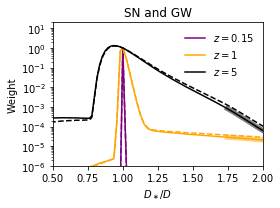

In [49]:
# Lensing weights for transient GW and EM sources, luminosity distance 

plt.figure(figsize=(4, 3))
colors = ['purple', 'orange', 'k']
for i, z in enumerate([0.15, 1, 5]):
    z_p_a = np.array([z_p(z, mui) for mui in mu])
    dlr = dl(z_p_a)/dl(z)
    M_p_a = (1+z)/(1+z_p_a)
    
    PmuGW = Pmu(mu, z_p_a)
    taumu = np.interp(z_p_a, filetau[:,0], filetau[:, 1])
    PmuGW2 = taumu / mu**(3.) / 0.005
        
    J = dl_p(z)/dl_p(z_p_a) * np.sqrt(mu) * (1+z)/(1+z_p_a)
    JSN = dl_p(z)/dl_p(z_p_a) * np.sqrt(mu)
    V = E(z)/E(z_p_a) * mu * ((1+z_p_a)/(1+z))**(-2.)
    Evo = ((1+z_p_a)/(1+z))**(betagw)
    Grad = np.gradient(mu, dlr)
    R = (1+z)/(1+z_p_a)
    Evo[z_p_a>2.] = Evo[z_p_a>2.] * ((1+z_p_a[z_p_a>2.])/(1+2.))**(-2*betagw)
    Evo[z_p_a>10] = np.nan
    
    
    KSN = JSN*V*Evo*R*PmuGW*np.abs(Grad)
    KGW = J*V*R*PmuGW * np.abs(Grad)*Evo
    
    
    norm = np.trapz((KGW)[np.isfinite(KGW)], dlr[np.isfinite(KGW)])
    avg =  np.trapz((KGW*dlr)[np.isfinite(KGW)], dlr[np.isfinite(KGW)]) / norm
    std = np.trapz((KGW*(dlr-avg)**2.)[np.isfinite(KGW)], dlr[np.isfinite(KGW)]) /norm
    skew = np.trapz((KGW*(dlr-avg)**3.)[np.isfinite(KGW)], dlr[np.isfinite(KGW)]) /norm
    #print("average:", avg)
    #print("Std:", np.sqrt(std))
    #print("skewness:", skew)
    

    KSN = KSN/KSN[mu==1]
    KGW = KGW/KGW[mu==1]
    plt.semilogy(dlr, KSN, color=colors[i], ls='--')
    plt.plot(dlr, KGW, label="$z="+str(z)+"$", color=colors[i])
    plt.plot(dlr[mu>3], KGW[mu>3], color=colors[i], lw=5, alpha=0.5)

plt.title("SN and GW")
plt.gca().set_xlabel(r'$D_\ast/D$')
plt.gca().set_ylabel(r'Weight')
plt.gca().set_ylim([1e-6, 20])
plt.gca().set_xlim([0.5, 2])
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

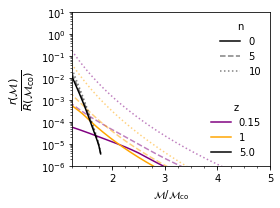

In [53]:
# Lensing tail

colors = ['purple', 'orange', 'k']
plt.figure(figsize=(4, 3))
plot_lines = [None, None, None]
for i, z in enumerate([0.15, 1, 5.]):
    z_p_a = np.array([z_p(z, mui) for mui in mu])
    M_p_a = (1+z)/(1+z_p_a)
    
    PmuGW = Pmu(mu, z_p_a, tail=True)
    
    J = dl_p(z)/dl_p(z_p_a) * np.sqrt(mu) * (1+z)/(1+z_p_a)
    V = E(z)/E(z_p_a) * mu * ((1+z_p_a)/(1+z))**(-2.)
    Evo = ((1+z_p_a)/(1+z))**(betagw)
    Grad = np.gradient(mu, M_p_a)
    R = (1+z)/(1+z_p_a)
    
    if(z<=2):
        Evo[z_p_a>2.] = Evo[z_p_a>2.] * ((1+z_p_a[z_p_a>2.])/(1+2.))**(-2*betagw)
    else:
        Evo[z_p_a>2.] = ((1+z_p_a[z_p_a>2.])/(1.+z))**(-betagw)
    Evo[z_p_a>10] = np.nan
    
    KGW = J*V*R*PmuGW*np.abs(Grad)*Evo

    for n in [0, 5, 10]:
        y = KGW[::-1] * (M_p_a[::-1]**(-n))
        x = M_p_a[::-1]
        mm = mu[::-1]
        zz = z_p_a[::-1]
        idx = np.isfinite(y)
        x = x[idx]
        y = y[idx]
        mm = mm[idx][1:]
        zz = zz[idx]
        if(n==0.):
            l, = plt.semilogy(1./x[1:], cumtrapz(y, x)/x[1:]**(-n), color=colors[i], label=z)
            plot_lines[0] = l 
        if(n==5):
            l, = plt.semilogy(1./x[1:], cumtrapz(y, x)/x[1:]**(-n), color=colors[i], ls='--', alpha=0.5)
            plot_lines[1] = l 
        if(n==10):
            l, = plt.semilogy(1./x[1:], cumtrapz(y, x)/x[1:]**(-n), color=colors[i], ls=':', alpha=0.5)
            plot_lines[2] = l 
    
plt.gca().set_xlabel(r'$\mathcal{M}/\mathcal{M}_{\mathrm{co}}$')
plt.gca().set_ylabel(r'$\frac{r(\mathcal{M})}{R(\mathcal{M}_{\mathrm{co}})}$', fontsize=16)
plt.gca().set_ylim([1e-6, 10.])
plt.gca().set_xlim([1.25, 5])
plt.gca().xaxis.set_minor_locator(MultipleLocator(0.25))

legend1 = plt.legend(frameon=False, title='z', loc=4)
plt.legend([l for l in plot_lines], [0, 5, 10], title="n", frameon=False, loc=1)
plt.gca().add_artist(legend1)

plt.tight_layout()
plt.show()